In [1]:
import os
while not 'dataloaders' in os.listdir():
    os.chdir('../')
from rasterio.errors import NotGeoreferencedWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from dataloaders.mass_roads_dataloader import (
    MassRoadsDataset, custom_collate_fn, get_patch_sampler
)
from models.MULDE.models import MLPs, ScoreOrLogDensityNetwork
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


def calculate_metrics(predictions, targets, threshold=0.5):
    preds = (predictions > threshold).float().cpu().numpy().astype(np.uint8).flatten()
    targets = (targets > 0.5).float().cpu().numpy().astype(np.uint8).flatten()
    precision = precision_score(targets, preds, zero_division=1)
    recall = recall_score(targets, preds, zero_division=1)
    f1 = f1_score(targets, preds, zero_division=1)
    iou = jaccard_score(targets, preds, zero_division=1)
    return precision, recall, f1, iou

def save_model(log_density_model, optimizer, epoch, loss, path):
    directory = os.path.dirname(path)
    os.makedirs(directory, exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': log_density_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"Model saved at {path}")

def load_checkpoint(path, log_density_model, optimizer):
    if os.path.exists(path):
        # Note: Check the usage of 'weights_only'. If it's not supported by torch.load, remove it.
        checkpoint = torch.load(path, weights_only=True)
        log_density_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['epoch'], checkpoint['loss']
    return 0, None


DATA_DIR = '/home/ri/Desktop/Projects/Datasets/Mass_Roads/dataset/'
CHECKPOINT_PATH = 'checkpoints/RoadSegMulde/log_density_segmentation_checkpoint.pth'
BEST_MODEL_PATH = 'checkpoints/RoadSegMulde/best_log_density_segmentation_model.pth'

WINDOW_SIZE = 128
WINDOW_STRIDE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SIGMA_MIN = 0.1
SIGMA_MAX = 0.9
NUM_NOISE_LEVELS = 31
BATCH_SIZE = 16

LOAD_FROM = None #'last' # best or None
# LOAD_FROM = 'last' # best or None
DEBUG_LOSS_VALUES = True
# DEBUG_LOSS_VALUES = False

# arithmetic_noise = torch.linspace(SIGMA_MIN, SIGMA_MAX, steps=NUM_NOISE_LEVELS - 1).to(DEVICE)
def generate_geometric_noise_levels(sigma_min=0.05, sigma_max=0.9, num_levels=30, device="cuda"):
    r = (sigma_min / sigma_max) ** (1 / (num_levels - 1))
    geometric_noise_levels = sigma_max * (r ** torch.arange(num_levels, dtype=torch.float32, device=device))
    geometric_noise_levels, _ = torch.sort(geometric_noise_levels)
    return geometric_noise_levels

noise_levels = generate_geometric_noise_levels(SIGMA_MIN, SIGMA_MAX, NUM_NOISE_LEVELS - 1)
noise_levels = torch.cat([torch.tensor([0.0], device=DEVICE), noise_levels])
print("Generated Noise Levels:", noise_levels.cpu().numpy())

# --- Dataset Preparation ---
train_dataset = MassRoadsDataset(root_dir=DATA_DIR, split='train', window_size=WINDOW_SIZE, stride=WINDOW_STRIDE, max_images=5) # )#
val_dataset = MassRoadsDataset(root_dir=DATA_DIR, split='valid', window_size=WINDOW_SIZE, stride=WINDOW_STRIDE, max_images=5)
test_dataset = MassRoadsDataset(root_dir=DATA_DIR, split='test', window_size=WINDOW_SIZE, stride=WINDOW_STRIDE, max_images=5)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)




Generated Noise Levels: [0.         0.1        0.10787105 0.11636164 0.12552053 0.13540031
 0.14605772 0.15755402 0.16995516 0.18333243 0.19776262 0.21332861
 0.23011982 0.24823268 0.26777118 0.28884763 0.31158295 0.33610782
 0.36256304 0.39110056 0.4218843  0.45509103 0.49091145 0.5295513
 0.5712326  0.61619467 0.6646957  0.7170142  0.7734508  0.8343295
 0.9       ]
Total patches available: 2420
Total patches available: 2420
Total patches available: 2420


In [2]:
train_loss_history, val_loss_history = [], []
step_loss_history = []
steps, epochs_list = [], []
patch_count = 0  # Track total patches processed

# --- Load Pretrained ResNet for Feature Extraction ---
resnet = resnet50(pretrained=True)
resnet = nn.Sequential(
    *list(resnet.children())[:-2],
    nn.AdaptiveAvgPool2d((1, 1))
).to(DEVICE)
for param in resnet.parameters():
    param.requires_grad = False  
    param.grad = None  


# --- Model Setup ---
mlp = MLPs(
    input_dim=2048 + 1,  # ResNet features + noise conditioning
    output_dim=WINDOW_SIZE * WINDOW_SIZE,  # Pixel-wise log-density output
    units=[4096, 4096],
    layernorm=True,
    dropout=0.1
)
log_density_model = ScoreOrLogDensityNetwork(mlp, score_network=False).to(DEVICE)
optimizer = optim.Adam(log_density_model.parameters(), lr=1e-4, weight_decay=1e-5, betas=(0.9, 0.999))

# Load checkpoint if needed
start_epoch, best_loss = 0, float("inf")
if LOAD_FROM:
    checkpoint_path = CHECKPOINT_PATH if LOAD_FROM == 'last' else BEST_MODEL_PATH
    start_epoch, best_loss = load_checkpoint(checkpoint_path, log_density_model, optimizer)

def add_all_noise_levels_to_features(features, noise_levels):
    """
    Adds multiple noise levels to the extracted ResNet features.

    Args:
        features (torch.Tensor): Feature tensor from ResNet, shape (B, feature_dim).
        noise_levels (torch.Tensor): 1D tensor containing predefined noise levels.

    Returns:
        torch.Tensor: Features concatenated with their corresponding noise levels, 
                      shape (B * L, feature_dim + 1).
    """
    batch_size, feature_dim = features.shape
    num_levels = len(noise_levels)

    # Repeat features for each noise level
    repeated_features = features.repeat_interleave(num_levels, dim=0)  # (B * L, feature_dim)

    # Expand noise levels and concatenate
    noise_levels_expanded = noise_levels.repeat(batch_size, 1).T.flatten().unsqueeze(1)  # (B * L, 1)

    # Add noise to features
    noisy_features = repeated_features + torch.randn_like(repeated_features) * noise_levels_expanded

    # Concatenate noise level as an additional feature
    return torch.cat([noisy_features, noise_levels_expanded], dim=1)  # (B * L, feature_dim + 1)


import matplotlib.pyplot as plt

def live_plot(loss_history, step_history):
    plt.clf()
    plt.plot(step_history, loss_history, label='Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Progress')
    plt.legend()
    plt.pause(0.1)


TRAIN_METHOD = "Unsupervised"
# TRAIN_METHOD = "Hybrid

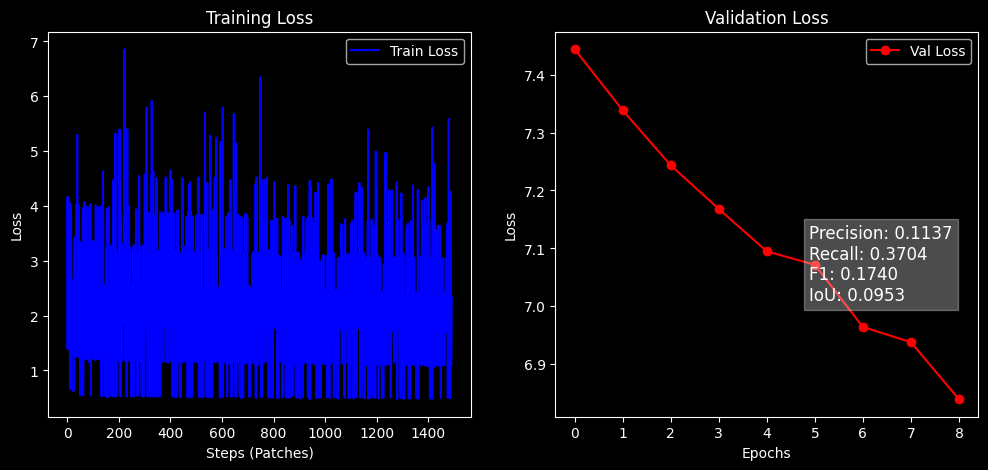

Training Epoch: 100%|██████████| 152/152 [00:47<00:00,  3.18it/s]


Training  - Loss DSM: 23034660.0 , Weighted: 2.3034660816192627, Loss Seg: 0.017291218042373657, Loss Total: 2.3207573890686035
Training  - Loss DSM: 11265309.0 , Weighted: 1.1265308856964111, Loss Seg: 0.01682358980178833, Loss Total: 1.1433544158935547


Validation Epoch:   3%|▎         | 5/152 [00:01<00:36,  4.07it/s]

Validation  - Loss DSM: 23277852.0 , Weighted: 2.3277852535247803, Loss Seg: 0.014226287603378296, Loss Total: 2.3420114517211914


Validation Epoch:   7%|▋         | 10/152 [00:02<00:38,  3.65it/s]

Validation  - Loss DSM: 23049904.0 , Weighted: 2.304990530014038, Loss Seg: 0.01615855097770691, Loss Total: 2.3211491107940674


Validation Epoch:  10%|▉         | 15/152 [00:03<00:35,  3.81it/s]

Validation  - Loss DSM: 96698208.0 , Weighted: 9.669820785522461, Loss Seg: 0.010539978742599487, Loss Total: 9.680360794067383


Validation Epoch:  13%|█▎        | 20/152 [00:05<00:32,  4.07it/s]

Validation  - Loss DSM: 61661044.0 , Weighted: 6.166104316711426, Loss Seg: 0.00802263617515564, Loss Total: 6.174127101898193


Validation Epoch:  16%|█▋        | 25/152 [00:06<00:29,  4.36it/s]

Validation  - Loss DSM: 29856438.0 , Weighted: 2.9856438636779785, Loss Seg: 0.00752335786819458, Loss Total: 2.9931671619415283


Validation Epoch:  20%|█▉        | 30/152 [00:07<00:28,  4.22it/s]

Validation  - Loss DSM: 77920712.0 , Weighted: 7.792071342468262, Loss Seg: 0.007857739925384521, Loss Total: 7.799929141998291


Validation Epoch:  23%|██▎       | 35/152 [00:08<00:28,  4.08it/s]

Validation  - Loss DSM: 74187776.0 , Weighted: 7.4187774658203125, Loss Seg: -0.01160767674446106, Loss Total: 7.407169818878174


Validation Epoch:  26%|██▋       | 40/152 [00:09<00:27,  4.05it/s]

Validation  - Loss DSM: 69057448.0 , Weighted: 6.905745029449463, Loss Seg: 0.001683741807937622, Loss Total: 6.907428741455078


Validation Epoch:  30%|██▉       | 45/152 [00:11<00:27,  3.90it/s]

Validation  - Loss DSM: 88260904.0 , Weighted: 8.826090812683105, Loss Seg: 0.000459134578704834, Loss Total: 8.826549530029297


Validation Epoch:  33%|███▎      | 50/152 [00:12<00:26,  3.91it/s]

Validation  - Loss DSM: 97107120.0 , Weighted: 9.710712432861328, Loss Seg: -0.0035210847854614258, Loss Total: 9.707191467285156


Validation Epoch:  36%|███▌      | 55/152 [00:13<00:24,  4.00it/s]

Validation  - Loss DSM: 100954344.0 , Weighted: 10.095434188842773, Loss Seg: -0.002744913101196289, Loss Total: 10.092689514160156


Validation Epoch:  39%|███▉      | 60/152 [00:14<00:23,  3.98it/s]

Validation  - Loss DSM: 55036876.0 , Weighted: 5.503687858581543, Loss Seg: -0.00841522216796875, Loss Total: 5.495272636413574


Validation Epoch:  43%|████▎     | 65/152 [00:16<00:21,  4.11it/s]

Validation  - Loss DSM: 69418360.0 , Weighted: 6.941835880279541, Loss Seg: 0.003039836883544922, Loss Total: 6.944875717163086


Validation Epoch:  46%|████▌     | 70/152 [00:17<00:19,  4.31it/s]

Validation  - Loss DSM: 54080212.0 , Weighted: 5.408021450042725, Loss Seg: 0.004830420017242432, Loss Total: 5.412851810455322


Validation Epoch:  49%|████▊     | 74/152 [00:18<00:17,  4.43it/s]

In [ ]:
########################################################################
# If you want to switch between training modes, set TRAIN_METHOD to either:
#   "Unsupervised"  (only DSM loss is used)
#   "Hybrid"        (DSM loss + segmentation loss)
########################################################################

TRAIN_METHOD = "Hybrid"  # or "Unsupervised"
RETURN_LOG_DENSITY = True  # Set to True to use log density score for DSM loss
RETURN_LOG_DENSITY = False

NUM_EPOCHS = 20

DSM_WEIGHT = 1/((WINDOW_SIZE**4))  # weight for DSM loss in the hybrid loss
DSM_WEIGHT = 1e-7  # Adjust to make DSM loss comparable to segmentation loss

LIVE_STEPS = 500  # Number of steps between live plots
LIVE_STEPS = 15  # Number of steps between live plots
# ----------------------------------------------------------------------------
# Modify the function to return the noise that was added as well.
# ----------------------------------------------------------------------------
def add_all_noise_levels_to_features(features, noise_levels):
    """
    Adds multiple noise levels to the extracted ResNet features and also returns the
    added noise and the noise level for each sample.

    Args:
        features (torch.Tensor): Feature tensor from ResNet, shape (B, feature_dim).
        noise_levels (torch.Tensor): 1D tensor containing predefined noise levels.

    Returns:
        features_with_noise_level (torch.Tensor): Tensor of shape (B * L, feature_dim + 1)
            where the additional column contains the noise level.
        noise (torch.Tensor): The noise that was added (shape: (B * L, feature_dim)).
        sigma_expanded (torch.Tensor): The noise level (sigma) corresponding to each sample,
            shape (B * L, 1).
    """
    batch_size, feature_dim = features.shape
    num_levels = len(noise_levels)
    
    # Repeat features for each noise level: shape (B * L, feature_dim)
    repeated_features = features.repeat_interleave(num_levels, dim=0)
    
    # Expand noise levels: shape (B * L, 1)
    sigma_expanded = noise_levels.repeat(batch_size, 1).T.flatten().unsqueeze(1)
    
    # Draw noise from N(0, I) and scale by sigma
    noise = torch.randn_like(repeated_features) * sigma_expanded
    
    # Add noise to features
    noisy_features = repeated_features + noise
    
    # Concatenate the noise level as an extra feature
    features_with_noise_level = torch.cat([noisy_features, sigma_expanded], dim=1)
    
    return features_with_noise_level, noise, sigma_expanded



########################################################################
# Live Plot Helper (Jupyter-Compatible)
########################################################################
class LivePlotter:
    def __init__(self, steps=LIVE_STEPS):
        self.train_steps = []
        self.train_losses = []
        self.val_epochs = []
        self.val_losses = []
        self.precision_list = []
        self.recall_list = []
        self.f1_list = []
        self.iou_list = []
        self.step_count = 0
        self.steps = steps
        # Initialize figure
        self.fig, self.ax = plt.subplots(1, 2, figsize=(12, 5))

    def update_train_plot(self, loss):
        """Update training loss plot every steps"""
        self.step_count += 1
        self.train_steps.append(self.step_count)
        self.train_losses.append(loss)

        if self.step_count % self.steps == 0: 
            clear_output(wait=True)  # Clear previous output
            self.ax[0].clear()
            self.ax[0].plot(self.train_steps, self.train_losses, label="Train Loss", color="blue")
            self.ax[0].set_xlabel("Steps (Patches)")
            self.ax[0].set_ylabel("Loss")
            self.ax[0].set_title("Training Loss")
            self.ax[0].legend()
            
            display(self.fig)  # Show updated plot

    def update_val_plot(self, val_loss, precision, recall, f1, iou):
        """Update validation loss & metrics plot"""
        self.val_epochs.append(len(self.val_epochs)) 
        self.val_losses.append(val_loss)
        self.precision_list.append(precision)
        self.recall_list.append(recall)
        self.f1_list.append(f1)
        self.iou_list.append(iou)

        # Clear previous output for smooth updating
        clear_output(wait=True)

        # Validation loss plot
        self.ax[1].clear()
        self.ax[1].plot(self.val_epochs, self.val_losses, label="Val Loss", marker="o", color="red")
        self.ax[1].set_xlabel("Epochs")
        self.ax[1].set_ylabel("Loss")
        self.ax[1].set_title("Validation Loss")
        self.ax[1].legend()

        # Add metrics as text on plot
        text_str = f"Precision: {precision:.4f}\nRecall: {recall:.4f}\nF1: {f1:.4f}\nIoU: {iou:.4f}"
        self.ax[1].text(0.6, 0.5, text_str, transform=self.ax[1].transAxes, fontsize=12,
                        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.3))

        display(self.fig)  # Show updated figure

    def save_plots(self):
        """Save final plots after training"""
        self.fig.savefig("training_validation_plot.png")
        print("Saved Training and Validation Loss Plots")


# Initialize live plotter for Jupyter Notebook
plotter = LivePlotter()
images, targets, _ = next(iter(train_loader))
print(f"Images Shape: {images.shape}, Targets Shape: {targets.shape}")



# ----------------------------------------------------------------------------
# Define a helper segmentation loss function.
# Here we mimic your earlier segmentation loss formulation
# (MSE loss plus a term based on the negative mean prediction).
# You can replace it with cross-entropy, Dice loss, etc.
# ----------------------------------------------------------------------------
# def segmentation_loss(predictions, targets):
#     # predictions: (B, H, W), already passed through a sigmoid
#     targets = targets.float()
#     mse_loss = F.mse_loss(predictions, targets)
#     log_likelihood_loss = -predictions.mean()
#     return mse_loss + log_likelihood_loss

def segmentation_loss(predictions, targets, mse_weight=0.5, bce_weight=0.3, dice_weight=0.2, smooth=1.0):
    """
    Combined loss for segmentation:
    - MSE Loss: Pixel-wise similarity.
    - BCE Loss: Per-pixel classification.
    - Dice Loss: Encourages better overlap with ground truth.
    
    Args:
        predictions (torch.Tensor): Model output after sigmoid (B, H, W).
        targets (torch.Tensor): Ground truth binary masks (B, H, W).
        mse_weight (float): Weight for MSE loss.
        bce_weight (float): Weight for BCE loss.
        dice_weight (float): Weight for Dice loss.
        smooth (float): Smoothing factor to avoid division by zero.
    
    Returns:
        torch.Tensor: Weighted sum of MSE, BCE, and Dice losses.
    """
    targets = targets.float()

    # --- MSE Loss ---
    mse_loss = F.mse_loss(predictions, targets)

    # --- Binary Cross-Entropy (BCE) Loss ---
    bce_loss = F.binary_cross_entropy(predictions, targets)

    # --- Dice Loss ---
    intersection = (predictions * targets).sum(dim=(1, 2))
    dice_loss = 1 - (2.0 * intersection + smooth) / (predictions.sum(dim=(1, 2)) + targets.sum(dim=(1, 2)) + smooth)
    dice_loss = dice_loss.mean()  # Average over batch

    # --- Final Weighted Loss ---
    total_loss = mse_weight * mse_loss + bce_weight * bce_loss + dice_weight * dice_loss

    log_likelihood_loss = -predictions.mean()
    total_loss += log_likelihood_loss
    return total_loss

# ----------------------------------------------------------------------------
# Training loop (one epoch)
# ----------------------------------------------------------------------------
def train_epoch():
    global patch_count
    log_density_model.train()
    running_loss = 0.0
    patch_count = 0

    for batch_idx, batch in enumerate(tqdm(train_loader, desc="Training Epoch")):
        images, targets, _ = batch
        if images is None:
            continue
        images = images.to(DEVICE)
        targets = targets.to(DEVICE).float()
        batch_size = images.shape[0]
        
        # Extract features from images using the pretrained ResNet
        # resnet returns shape (B, feature_dim, 1, 1) so we squeeze twice.
        features = resnet(images).squeeze(-1).squeeze(-1)  # shape: (B, 2048)
        
        # Add noise at all predefined levels.
        # This returns:
        #   - features_with_noise_level: (B * L, feature_dim+1)
        #   - noise: the noise that was added, (B * L, feature_dim)
        #   - sigma_expanded: the noise level per sample, (B * L, 1)
        features_with_noise, noise_added, sigma_expanded = add_all_noise_levels_to_features(features, noise_levels)
        # features_with_noise.requires_grad_(True)
        features_with_noise = features_with_noise.clone().detach().requires_grad_(True)

        # --- DSM (unsupervised) branch ---
        # Call the .score() method which returns both the score prediction and log density.
        # (The ScoreOrLogDensityNetwork is set up so that its score() method accepts a tensor
        #  with concatenated noise-level as the last column.)
        score_pred, log_density_pred = log_density_model.score(features_with_noise, return_log_density=RETURN_LOG_DENSITY)
        
        # Compute DSM loss only for nonzero noise levels (avoid division by zero)
        nonzero_mask = (sigma_expanded != 0).squeeze()  # Boolean mask
        
        nonzero_mask = (sigma_expanded != 0).squeeze()
        loss_dsm = torch.tensor(0.0, device=DEVICE)
        if nonzero_mask.sum() > 0:
            score_nonzero = score_pred[nonzero_mask]
            noise_nonzero = noise_added[nonzero_mask]
            sigma_nonzero = sigma_expanded[nonzero_mask]
            lambda_factor = sigma_nonzero ** 2
            # Exclude the last dimension (which holds the noise-level)
            # and compare with the scaled noise.
            dsm_term = torch.norm(score_nonzero[:, :-1] + noise_nonzero / (sigma_nonzero ** 2), dim=-1) ** 2
            loss_dsm = (lambda_factor * dsm_term).sum() / batch_size  # Normalize by patches

        
        # --- Segmentation branch ---
        # Use only the "clean" branch (where sigma == 0) to obtain segmentation predictions.
        clean_mask = (sigma_expanded == 0).squeeze()
        loss_seg = torch.tensor(0.0, device=DEVICE)
        if clean_mask.sum() > 0:
            clean_log_density = log_density_pred[clean_mask]  # shape: (B, WINDOW_SIZE*WINDOW_SIZE)
            # Reshape to (B, WINDOW_SIZE, WINDOW_SIZE) and apply sigmoid to get probabilities.
            seg_pred = torch.sigmoid(clean_log_density).view(-1, WINDOW_SIZE, WINDOW_SIZE)
            loss_seg = segmentation_loss(seg_pred, targets)
            
        
        # --- Combine losses based on the chosen training mode ---
        if TRAIN_METHOD == "Unsupervised":
            loss = loss_dsm
        elif TRAIN_METHOD == "Hybrid":
            loss = loss_seg + DSM_WEIGHT * loss_dsm
        else:
            # Default to segmentation only if no valid training mode is selected.
            loss = loss_seg
        
        if DEBUG_LOSS_VALUES and (batch_idx + 1) % 5 == 0:
            print(f"Training  - Loss DSM: {loss_dsm.item()} , Weighted: {DSM_WEIGHT * loss_dsm}, Loss Seg: {loss_seg.item()}, Loss Total: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_size
        patch_count += batch_size

        plotter.update_train_plot(loss.item()) # Update the training plot with the current loss value
    
    avg_loss = running_loss / patch_count

    return avg_loss


# ----------------------------------------------------------------------------
# Validation loop (one epoch)
# For hybrid training, we also compute segmentation metrics.
# ----------------------------------------------------------------------------
def validate_epoch():
    log_density_model.eval()
    total_loss = 0.0
    patch_count = 0
    seg_preds_list = []
    seg_targets_list = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(val_loader, desc="Validation Epoch")):
            images, targets, _ = batch
            if images is None:
                continue

            images = images.to(DEVICE)
            targets = targets.to(DEVICE).float()
            batch_size = images.shape[0]
        
            features = resnet(images).squeeze(-1).squeeze(-1)

             # Remove `torch.no_grad()` inside the loop for DSM loss computation
            with torch.enable_grad():  # Enable gradient computation for DSM loss
                features_with_noise, noise_added, sigma_expanded = add_all_noise_levels_to_features(features, noise_levels)
                features_with_noise.requires_grad_(True)  # Ensure gradients are tracked

                score_pred, log_density_pred = log_density_model.score(features_with_noise, return_log_density=RETURN_LOG_DENSITY)
                
                # Compute DSM loss
                nonzero_mask = (sigma_expanded != 0).squeeze()
                loss_dsm = torch.tensor(0.0, device=DEVICE)
                if nonzero_mask.sum() > 0:
                    score_nonzero = score_pred[nonzero_mask]
                    noise_nonzero = noise_added[nonzero_mask]
                    sigma_nonzero = sigma_expanded[nonzero_mask]
                    lambda_factor = sigma_nonzero ** 2
                    dsm_term = torch.norm(score_nonzero[:, :-1] + noise_nonzero / (sigma_nonzero ** 2), dim=-1) ** 2
                    loss_dsm = (lambda_factor * dsm_term).sum() / batch_size  # Normalize by patches

            
            # Re-enable `torch.no_grad()` for segmentation loss evaluation
            with torch.no_grad():
                clean_mask = (sigma_expanded == 0).squeeze()
                loss_seg = torch.tensor(0.0, device=DEVICE)
                if clean_mask.sum() > 0:
                    clean_log_density = log_density_pred[clean_mask]
                    seg_pred = torch.sigmoid(clean_log_density).view(-1, WINDOW_SIZE, WINDOW_SIZE)
                    loss_seg = segmentation_loss(seg_pred, targets)
                    seg_preds_list.append(seg_pred)
                    seg_targets_list.append(targets)
                    
                if TRAIN_METHOD == "Unsupervised":
                    loss = loss_dsm
                elif TRAIN_METHOD == "Hybrid":
                    loss = loss_seg + DSM_WEIGHT * loss_dsm
                else:
                    loss = loss_seg
                
                total_loss += loss.item() * batch_size
                patch_count += batch_size

            avg_val_loss = total_loss / patch_count  # Normalize by patches


            
            if TRAIN_METHOD == "Unsupervised":
                loss = loss_dsm
            elif TRAIN_METHOD == "Hybrid":
                loss = loss_seg + DSM_WEIGHT * loss_dsm
            else:
                loss = loss_seg
            
            if DEBUG_LOSS_VALUES and (batch_idx + 1) % 5 == 0:
                print(f"Validation  - Loss DSM: {loss_dsm.item()} , Weighted: {DSM_WEIGHT * loss_dsm}, Loss Seg: {loss_seg.item()}, Loss Total: {loss.item()}")       
            total_loss += loss.item() * batch_size
            patch_count += batch_size
            
    
    avg_val_loss = total_loss / patch_count # Normalize by patches

    
    if TRAIN_METHOD == "Hybrid" and seg_preds_list:
        seg_preds_all = torch.cat(seg_preds_list, dim=0)
        seg_targets_all = torch.cat(seg_targets_list, dim=0)
        precision, recall, f1, iou = calculate_metrics(seg_preds_all, seg_targets_all)
        print(f"Validation Segmentation Metrics - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, IoU: {iou:.4f}")
        plotter.update_val_plot(avg_val_loss, precision, recall, f1, iou)
    
    return avg_val_loss


# ----------------------------------------------------------------------------
# Main training loop
# ----------------------------------------------------------------------------
best_val_loss = float("inf")
for epoch in range(start_epoch, NUM_EPOCHS):
    train_loss = train_epoch()
    val_loss = validate_epoch()
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")
    
    # Save the model if the validation loss improved.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"Saving best model at epoch {epoch+1} with val loss {val_loss:.4f}")
        save_model(log_density_model, optimizer, epoch, val_loss, BEST_MODEL_PATH)

    save_model(log_density_model, optimizer, epoch, val_loss, CHECKPOINT_PATH)


# ----------------------------------------------------------------------------
# Optionally, define a test function to evaluate the model on the test set.
# ----------------------------------------------------------------------------
def test_model():
    log_density_model.eval()
    seg_preds_list = []
    seg_targets_list = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            images, targets, _ = batch
            images = images.to(DEVICE)
            targets = targets.to(DEVICE).float()
            if images is None:
                continue
            features = resnet(images).squeeze(-1).squeeze(-1)
            features_with_noise, noise_added, sigma_expanded = add_all_noise_levels_to_features(features, noise_levels)

            score_pred, log_density_pred = log_density_model.score(features_with_noise, return_log_density=RETURN_LOG_DENSITY)
            
            clean_mask = (sigma_expanded == 0).squeeze()
            if clean_mask.sum() > 0:
                clean_log_density = log_density_pred[clean_mask]
                seg_pred = torch.sigmoid(clean_log_density).view(-1, WINDOW_SIZE, WINDOW_SIZE)
                seg_preds_list.append(seg_pred)
                seg_targets_list.append(targets)
    
    if seg_preds_list:
        seg_preds_all = torch.cat(seg_preds_list, dim=0)
        seg_targets_all = torch.cat(seg_targets_list, dim=0)
        precision, recall, f1, iou = calculate_metrics(seg_preds_all, seg_targets_all)
        print(f"Test Metrics - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, IoU: {iou:.4f}")

# Run testing after training
test_model()


In [ ]:
28198060.0 / 128 /128 / 32 / 32